# A Study of the TextRank Algorithm in Python

[TextRank](http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf) is
a key phrase and sentence extraction algorithm based on
[PageRank](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf). I've made an
IPython notebook to demonstrate how to implement it using the
[networkx](https://networkx.github.io/) and
[NLTK](http://www.nltk.org/) packages. I also use
[matplotlib](http://matplotlib.org/) to visualize the graph.


## Setup

First, let's import NLTK, and make sure that we have the NLTK packages we need.

In [1]:
import nltk

In [ ]:
# Install the following packages. This may take a few seconds if you haven't had them installed.
packages = (
    "stopwords",  # for stopwords definition
    "punkt",  # for tokenizing sentences
    "maxent_treebank_pos_tagger",  # for part-of-speech (POS) tagging,
    "averaged_perceptron_tagger",
)

for package in packages:
    nltk.download(package)

In [2]:
# Let's see what NLTK can do for us here.
#
# First, tokenization: we want to break a text into tokens.
text = 'Python is a programming language.'
tokens = nltk.word_tokenize(text)
print(tokens)

['Python', 'is', 'a', 'programming', 'language', '.']


In [3]:
# Part-of-speech (POS) tagging: Identify the function of a word.
tagged_tokens = nltk.pos_tag(tokens)
print(tagged_tokens[:10])

[('Python', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('programming', 'JJ'), ('language', 'NN'), ('.', '.')]


In [4]:
# Getting n-grams: A unigram (1-gram) is just a word itself,
# whereas a bigram (2-gram) is a pair, trigram/3-gram a triple,
# and so on. Here we use NLTK to get bigrams. We show the difference
# between getting untagged and tagged bigrams.
untagged_bigrams = nltk.ngrams(tokens, 2)
print(list(untagged_bigrams)[:10])

[('Python', 'is'), ('is', 'a'), ('a', 'programming'), ('programming', 'language'), ('language', '.')]


In [5]:
tagged_bigrams = nltk.ngrams(tagged_tokens, 2)
print(list(tagged_bigrams)[:10])

[(('Python', 'NNP'), ('is', 'VBZ')), (('is', 'VBZ'), ('a', 'DT')), (('a', 'DT'), ('programming', 'JJ')), (('programming', 'JJ'), ('language', 'NN')), (('language', 'NN'), ('.', '.'))]


In [6]:
# Stemming: Get the "stem" of a word.
#
# This allows us to ignore word forms. It's related to, but not exactly the same as,
# lemmatization.
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
print(stemmer.stem('run'))
print(stemmer.stem('runs'))
print(stemmer.stem('running'))

run
run
run


In [7]:
# Now let's extract some text. This is from Wikipedia:
# https://en.wikipedia.org/wiki/Python_(programming_language)
text = """
Python is a widely used general-purpose, high-level programming language.[19][20][21] Its design philosophy emphasizes code readability, and its syntax allows programmers to express concepts in fewer lines of code than would be possible in languages such as C++ or Java.[22][23] The language provides constructs intended to enable clear programs on both a small and large scale.[24]
Python supports multiple programming paradigms, including object-oriented, imperative and functional programming or procedural styles. It features a dynamic type system and automatic memory management and has a large and comprehensive standard library.[25]
Python interpreters are available for installation on many operating systems, allowing Python code execution on a wide variety of systems. Using third-party tools, such as Py2exe or Pyinstaller,[26] Python code can be packaged into stand-alone executable programs for some of the most popular operating systems, allowing for the distribution of Python-based software for use on those environments without requiring the installation of a Python interpreter.
CPython, the reference implementation of Python, is free and open-source software and has a community-based development model, as do nearly all of its alternative implementations. CPython is managed by the non-profit Python Software Foundation.
Python was conceived in the late 1980s[27] and its implementation was started in December 1989[28] by Guido van Rossum at CWI in the Netherlands as a successor to the ABC language (itself inspired by SETL)[29] capable of exception handling and interfacing with the Amoeba operating system.[5] Van Rossum is Python's principal author, and his continuing central role in deciding the direction of Python is reflected in the title given to him by the Python community, benevolent dictator for life (BDFL).
About the origin of Python, Van Rossum wrote in 1996:[30]
Over six years ago, in December 1989, I was looking for a "hobby" programming project that would keep me occupied during the week around Christmas. My office ... would be closed, but I had a home computer, and not much else on my hands. I decided to write an interpreter for the new scripting language I had been thinking about lately: a descendant of ABC that would appeal to Unix/C hackers. I chose Python as a working title for the project, being in a slightly irreverent mood (and a big fan of Monty Python's Flying Circus).
Python 2.0 was released on 16 October 2000, and included many major new features including a full garbage collector and support for Unicode. With this release the development process was changed and became more transparent and community-backed.[31]
Python 3.0 (also called Python 3000 or py3k), a major, backwards-incompatible release, was released on 3 December 2008[32] after a long period of testing. Many of its major features have been backported to the backwards-compatible Python 2.6 and 2.7.[33]
"""

In [8]:
# Let's tokenize the text.
tokens = nltk.word_tokenize(text)
print(tokens[:20])

['Python', 'is', 'a', 'widely', 'used', 'general-purpose', ',', 'high-level', 'programming', 'language', '.', '[', '19', ']', '[', '20', ']', '[', '21', ']']


In [9]:
# Now let's tag the tokens with a part-of-speech (POS) tagger.
tagged_tokens = nltk.pos_tag(tokens)
print(tagged_tokens[:20])

[('Python', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('widely', 'RB'), ('used', 'VBN'), ('general-purpose', 'JJ'), (',', ','), ('high-level', 'JJ'), ('programming', 'NN'), ('language', 'NN'), ('.', '.'), ('[', 'CC'), ('19', 'CD'), (']', 'JJ'), ('[', '$'), ('20', 'CD'), (']', 'NNP'), ('[', 'VBD'), ('21', 'CD'), (']', 'NNP')]


In [10]:
# Before we build the graph, we need some helper functions.
import re
def is_word(token):
    """
    A token is a "word" if it begins with a letter.
    
    This is for filtering out punctuations and numbers.
    """
    return re.match(r'^[A-Za-z].+', token)

# We only take nouns and adjectives. See the paper for why this is recommended.
ACCEPTED_TAGS = {'NN', 'NNS', 'NNP', 'JJ'}

def is_good_token(tagged_token):
    """
    A tagged token is good if it starts with a letter and the POS tag is
    one of ACCEPTED_TAGS.
    """
    return is_word(tagged_token[0]) and tagged_token[1] in ACCEPTED_TAGS
    
def normalized_token(token):
    """
    Use stemmer to normalize the token.
    """
    return stemmer.stem(token.lower())

In [11]:
# Now let's build the graph.
import networkx
graph = networkx.Graph()

# Here, bigrams are "tagged bigrams".
bigrams = nltk.ngrams(tagged_tokens, 2)
for bg in bigrams:
    if all(is_good_token(t) for t in bg):
        normalized = [normalized_token(t[0]) for t in bg]
        graph.add_edge(*normalized)

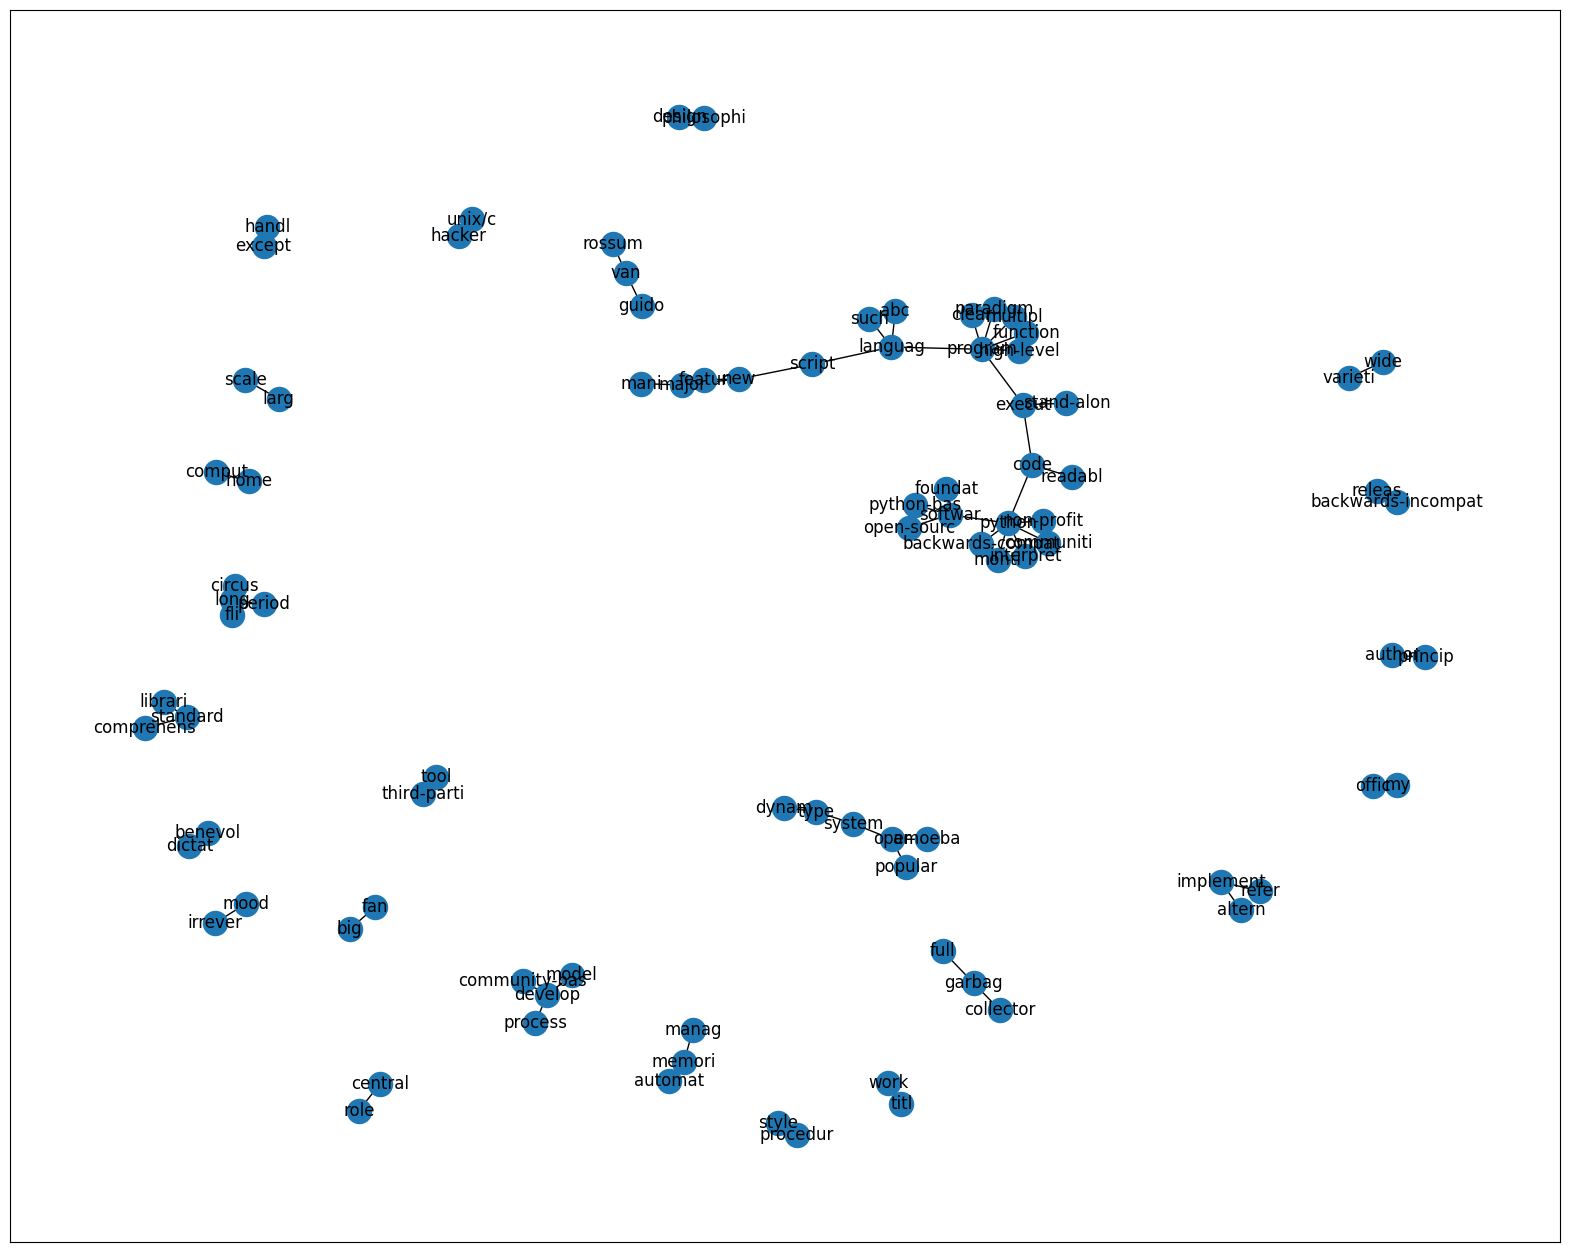

In [12]:
# We can visualize it with matplotlib.
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 16.0)
networkx.draw_networkx(graph)

In [13]:
# Let's do the PageRank.
pagerank = networkx.pagerank(graph)

In [14]:
# Then sort the nodes according to the rank.
ranked = sorted(pagerank.items(), key=lambda ns_pair: ns_pair[1], reverse=True)

In [15]:
# How many are there?
len(ranked)

89

In [16]:
# We only keep 30% of the top-ranking nodes.
selectivity = 0.30
remove_n = int(len(ranked) * selectivity)

In [17]:
# Now remove the nodes we don't need.
for node, _ in ranked[remove_n:]:
    graph.remove_node(node)

In [18]:
# Let's see how many are left.
len(graph)

26

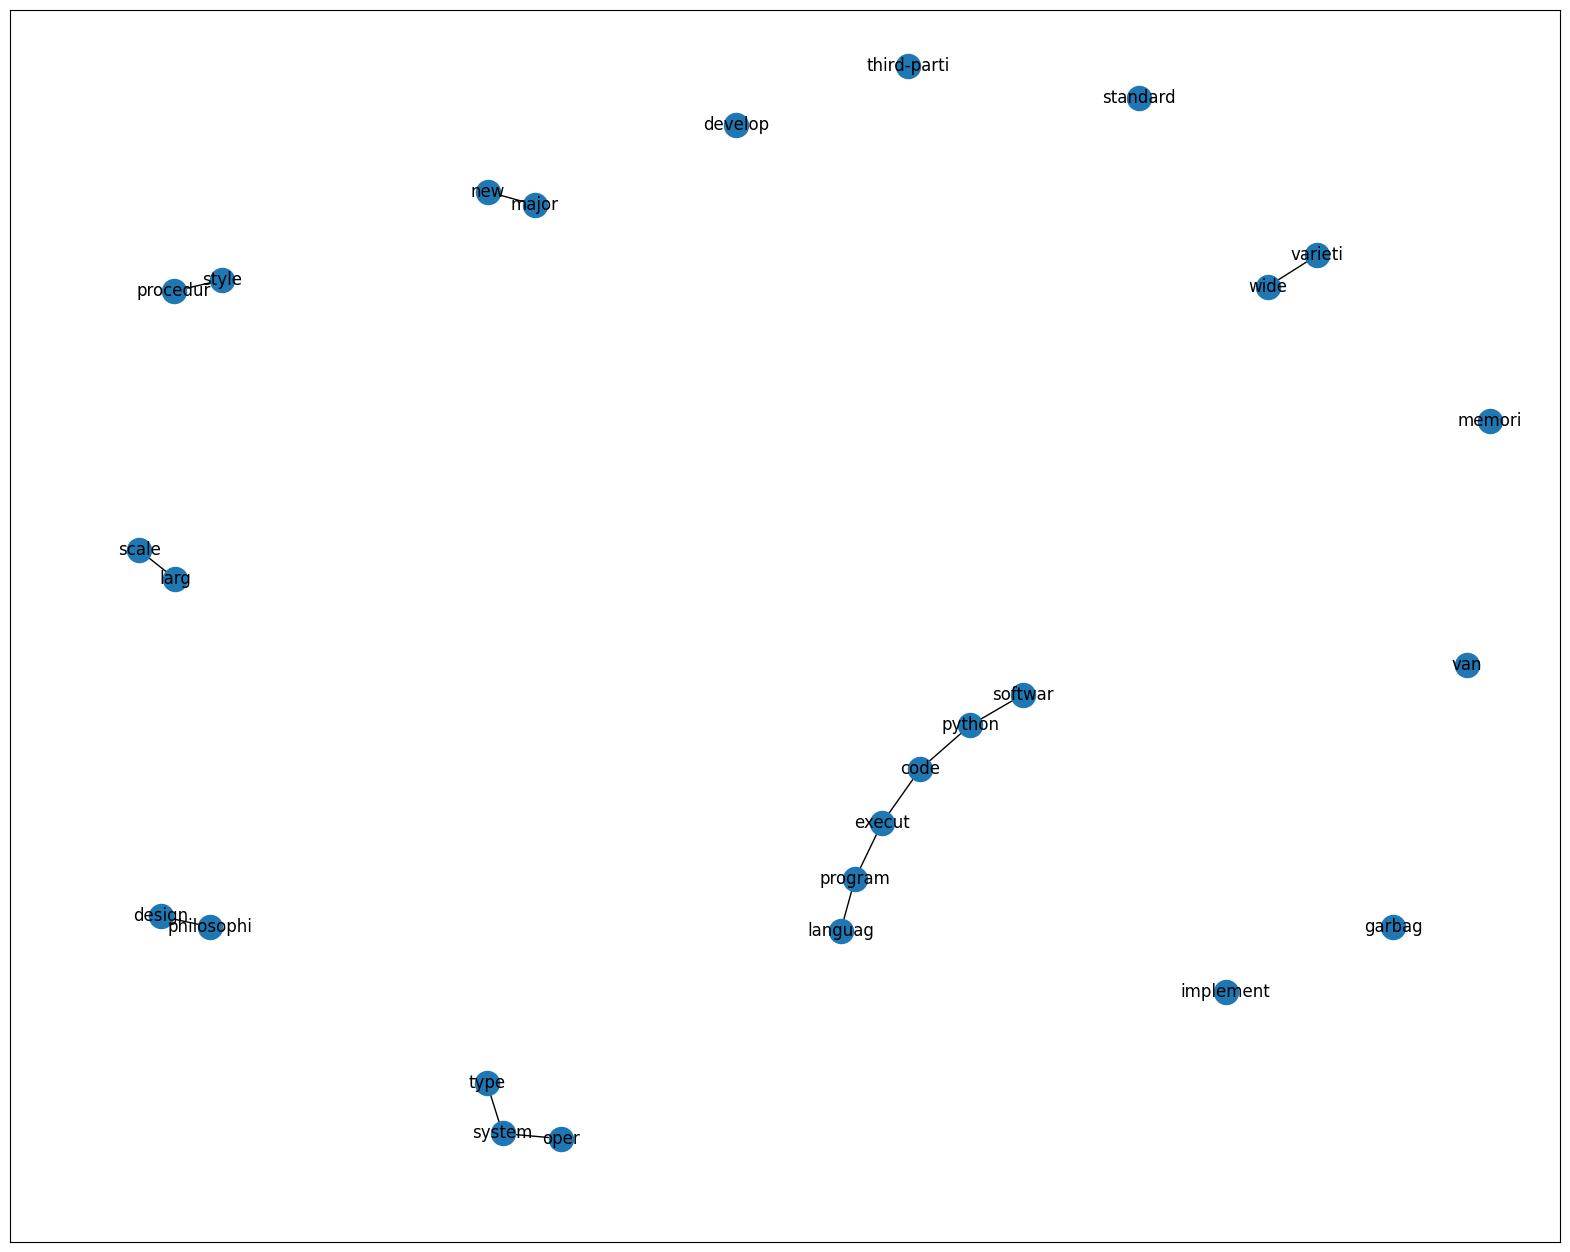

In [19]:
# Let's visualize it again.
networkx.draw_networkx(graph)

In [20]:
# Now let's recover the key phrases.
edges = {}
for edge in graph.edges:
    edges[edge[0]] = edge[1]
phrases = set()

# Using a "sliding window" of size 2, 3, 4:
for n in range(2, 5):
    
    # Get the 2-grams, 3-grams, 4-grams
    for ngram in nltk.ngrams(tokens, n):
        
        # For each n-gram, if all tokens are words, and if the normalized
        # head and tail are found in the graph -- i.e. if both are nodes
        # connected by an edge -- this n-gram is a key phrase.
        if all(is_word(token) for token in ngram):
            head, tail = normalized_token(ngram[0]), normalized_token(ngram[-1])
            
            if head in edges and tail in edges[head]:
                phrase = ' '.join(ngram)
                phrases.add(phrase)

In [21]:
# Finally, let's sort the phrases and print them out.
sorted_phrases = sorted(phrases, key=str.lower)
for p in sorted_phrases:
    print(p)

code execution
design philosophy
large scale
procedural styles
Python Software
type system
wide variety
